# Table of Contents

1. [Introduction](#1-introduction)  
   - [1.1 What this notebook covers](#11-what-this-notebook-covers)  
   - [1.2 Why this topic or project matters](#12-why-this-topic-or-project-matters)  

2. [Background](#2-background)  
   - [2.1 Fundamentals of network analysis](#21-fundamentals-of-network-analysis)  
       * Nodes, edges, weighted graphs, basic metrics (degree, centrality)  
   - [2.2 Co-occurrence as a proxy for semantic proximity](#22-co-occurrence-as-a-proxy-for-semantic-proximity)  
       * Why raw co-mentions can reveal thematic structure  
   - [2.3 Concept extraction in NLP](#23-concept-extraction-in-nlp)  
       * Supervised labeling (Watson NLU, spaCy, TF-IDF keywords) vs. unsupervised keyphrase methods  
   - [2.4 Comparison to other exploratory methods](#24-comparison-to-other-exploratory-methods)  
       * Topic modeling (LDA/BERTopic) vs. graph-based mapping  
       * Embedding-based similarity graphs  

3. [Objectives](#3-objectives)  
   - [3.1 What this notebook will demonstrate](#31-what-this-notebook-will-demonstrate)  
   - [3.2 Expected outcomes of the analysis](#32-expected-outcomes-of-the-analysis)  

4. [Setup](#4-setup)  
   - [4.1 Install/import libraries](#41-installimport-libraries)  
   - [4.2 Load and preview data](#42-load-and-preview-data)  

5. [Preprocessing](#5-preprocessing)  
   - [5.1 Data cleaning & concept filtering](#51-data-cleaning--concept-filtering)  
       * 5.1.1 Filtering by relevance, taxonomy & manual overrides  
       * 5.1.2 Normalizing strings & deduplication  
   - [5.2 Create initial DataFrames or dictionaries](#52-create-initial-dataframes-or-dictionaries)  
       * One for counts, one for edges (with weights)

6. [Graph Construction](#6-graph-construction)  
   - [6.1 Building the graph using NetworkX](#61-building-the-graph-using-networkx)  
     - [6.1.1 `nx.Graph` vs `nx.DiGraph` with weighted edges](#611-nxgraph-vs-nxdigraph-with-weighted-edges)  
   - [6.2 Directed vs undirected, weights, labels, etc.](#62-directed-vs-undirected-weights-labels-etc)  
   - [6.3 Visualizations (layout, color by emotion or function)](#63-visualizations-layout-color-by-emotion-or-function)  

7. [Graph Analysis](#7-graph-analysis)  
   - [7.1 Centrality, clustering, shortest paths, connected components](#71-centrality-clustering-shortest-paths-connected-components)  
   - [7.2 Subgraph exploration (e.g., emotion-specific clusters)](#72-subgraph-exploration-eg-emotion-specific-clusters)  

8. [Advanced Visualization](#8-advanced-visualization)  
   - [8.1 Using pyvis, Plotly, or enhanced NetworkX visuals](#81-using-pyvis-plotly-or-enhanced-networkx-visuals)  
   - [8.2 Interactive graph options](#82-interactive-graph-options)  

9. [Insights & Interpretation](#9-insights--interpretation)  
   - [9.1 What the graph reveals about emotional triggers, semantic structure, or Jakobsonian functions](#91-what-the-graph-reveals-about-emotional-triggers-semantic-structure-or-jakobsonian-functions)  
   - [9.2 Surprising or significant findings](#92-surprising-or-significant-findings)  

10. [Conclusion](#10-conclusion)  
    - [10.1 Summary of learnings](#101-summary-of-learnings)  
    - [10.2 Next steps or extensions](#102-next-steps-or-extensions)  

11. [Appendix (Optional)](#11-appendix-optional)  
    - [11.1 Notes on concept embeddings, model details, references](#111-notes-on-concept-embeddings-model-details-references)  
    - [11.2 Runtime notes, parameter tweaks](#112-runtime-notes-parameter-tweaks)  


### 1. Introduction

##### 1.1 What this notebook covers

In this notebook, we’ll explore how labeled concepts co-occur across a corpus to reveal thematic structures, key connectors, and emerging patterns. We’ll:

- **Extract concepts** using IBM Watson NLU (a supervised model trained on human-annotated data).  
- **Build an unsupervised co-occurrence network** by counting how often each pair of concepts appears together.  
- **Visualize and analyze** the resulting graph to generate hypotheses such as “Do concepts in the ‘care’ category cluster tightly?” or “Which ideas serve as bridges between topics?”

This workflow transforms raw NLU output into an interpretable map of concept relationships, setting the stage for deeper community detection or downstream graph analyses.

##### 1.2 Why this topic/project matters

Co-occurrence graphs are widely used to make sense of large text collections. They help practitioners:

| Role / Industry                | Purpose                                                                                         |
|--------------------------------|-------------------------------------------------------------------------------------------------|
| **Text-mining researchers**    | Map topic structures in news archives, academic papers, or survey responses.                    |
| **Data scientists & NLP teams**| Uncover hidden themes in customer feedback, social media, or support tickets.                   |
| **Digital humanists**          | Study how concepts (e.g., “war,” “peace,” “diplomacy”) cluster in historical texts.             |
| **Knowledge-management (KM)**  | Build internal concept maps to visualize how departments or documents interrelate.              |
| **Social-science researchers** | Analyze concept co-occurrence in interview transcripts or online communities.                   |

Key insights you can gain:

- **Thematic hot-spots:** Clusters of strongly connected nodes reveal major topics or concerns.  
- **Bridging concepts:** Nodes with high betweenness centrality indicate pivot ideas—ideal targets for messaging or intervention.  
- **Hidden correlations:** Unexpected pairings (e.g., “delivery” with “anxiety”) flag areas for qualitative follow-up.  
- **Trend detection:** Comparing graphs over time uncovers shifts in concept relationships.  
- **Dimensionality reduction:** Graph features (e.g., communities or embeddings) can feed into clustering or classification pipelines.

**Why your data is valuable**  
Your concepts come from human-annotated NLU, ensuring each node reflects a meaningful semantic unit. Rather than manually reviewing hundreds of documents, this network gives you a bird’s-eye view of all key terms and their interrelations, turning outliers and hubs into testable hypotheses. Plus, the same pipeline can apply to any corpus—support tickets, product reviews, legal filings, and beyond.

#### 1.3 Data scope and scalability

> **Note on sample size:**  
> In this notebook we work with a small subset of just 35 concepts so that each step (matrix builds, layout, community detection) runs instantly and the code remains easy to follow.  

> **Scalability:**  
> All of the same operations—binarizing a concept–document matrix, computing co-occurrence via sparse matrix multiplication, and running NetworkX (or graph-tool/igraph for very large graphs)—scale to thousands (or even millions) of concepts and documents. In production you’d simply switch to sparse data structures (e.g. `scipy.sparse`), a more performant graph library, and batch or distributed NLU extraction (Watson NLU, spaCy pipelines, etc.).  


---

### 2. Background

#### 2.1 Fundamentals of network analysis  
A **graph** (or network) is a mathematical structure of **nodes** (vertices) and **edges** (links). In text analysis:  
- **Nodes** represent units like words, phrases, or—here—pre-extracted concepts.  
- **Edges** represent associations (e.g. co-occurrence in the same document).  
- **Weighted edges** carry numeric values (e.g. co-occurrence counts), so stronger links stand out.

Key graph metrics:  

| Term                      | Definition                                                                             |
|---------------------------|----------------------------------------------------------------------------------------|
| **Degree**                | Number of edges connected to a node.                                                   |
| **Betweenness centrality**| Frequency a node lies on shortest paths between others—high values signal “bridges.”   |
| **Community**             | A cluster of nodes more densely connected to each other than to the rest of the graph. |
| **Layout algorithms**     | Methods (spring, circular, etc.) to arrange nodes for clearer visualization.           |

#### 2.2 Co-occurrence as a proxy for semantic proximity  
When two concepts appear together frequently, it often signals a thematic link. Raw co-mentions can uncover:  
- **Topics & subtopics:** clusters of tightly connected nodes point to major themes.  
- **Bridges & outliers:** high-betweenness nodes connect disparate themes; isolated nodes flag niche or mis-extracted terms.  
- **Evolution over time:** by slicing your data chronologically, you can track how these associations shift.

#### 2.3 Concept extraction in NLP  
Concepts can be pulled from text via:  
- **Supervised models** (Watson NLU, spaCy’s entity/concept extractors, TF-IDF keyword ranking)  
- **Unsupervised keyphrase methods** (RAKE, TextRank, YAKE)  

Use cases:  
- **Exploratory analysis:** surface major themes and emotional undertones in large corpora.  
- **Hypothesis generation:** test if, for example, “delivery” co-occurs more with “anxiety” than “satisfaction.”  
- **Feature engineering:** use node degrees or community labels in downstream classifiers (e.g. churn prediction).  
- **Emotion-aware applications:** tailor chatbots or alerts based on which emotional concepts dominate.

#### 2.4 Comparison to other exploratory methods  
- **Topic modeling (LDA, BERTopic):** probabilistic distributions of topics per document—good for broad strokes, but lacks explicit concept-to-concept links.  
- **Embedding similarity graphs:** connect concepts by semantic vector proximity—captures meaning beyond co-mentions, but requires embedding models and tuning.

> **Problem framing**  
> “Given a set of labeled concepts (with emotion tags), how can an unsupervised co-occurrence graph reveal thematic structures and emotional dynamics to inform further modeling or interventions?”


### 3. Objectives

#### 3.1 What this notebook will demonstrate

In this analysis, we will:

- **Detect hidden topic structures**  
  Apply community-detection (e.g. Louvain) to the co-occurrence network.  
  *Hypothesis:* Predefined concept groups (e.g. “care”–related terms) form distinct clusters.

- **Identify bridge concepts**  
  Measure betweenness centrality to find nodes connecting major clusters.  
  *Hypothesis:* High-betweenness nodes correspond to pivot ideas or key jargon.

- **Compare frequency vs. centrality**  
  Rank concepts by occurrence count, degree, and betweenness.  
  *Hypothesis:* The most frequent concepts are not always the most central or influential.

#### 3.2 Expected outcomes of the analysis

By the end of this notebook, you will have:

- A **visual co-occurrence graph** showing main communities and bridge nodes.  
- A **ranked table of concepts** by frequency, degree, and betweenness centrality.  
- **Community labels** for each concept, with an evaluation of alignment to known categories.  
- A list of **unexpected co-occurrences** flagged for deeper qualitative review.  
- A **reusable workflow** for exploratory concept-network analysis in any text corpus.


### 4. Setup

#### 4.1 Install/import libraries

In [ ]:
from notebook_service.cli import analyze_df
from notebook_service.graph_builder import (
    preprocess_concepts,
    compute_cooccurrence,
    build_semantic_graph,
    compute_centrality,
    detect_communities,
    node_to_community_map,
)
import pandas as pd
import networkx as nx
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from community import community_louvain  # python-louvain
from collections import Counter
from collections import defaultdict
from sklearn.metrics import silhouette_score
from sklearn.manifold import spectral_embedding
from sklearn.cluster import KMeans

pd.set_option("display.max_columns", None)

#### 4.2 Load and preview data

In [2]:
df = pd.read_csv("../data/input.csv")
nlu_df = analyze_df(df, text_column="entries")
nlu_df.head()

,entries,sadness,joy,fear,disgust,anger,concepts_raw,concepts,semantic_roles
0,"I felt anxious today, so I impulsively ordered...",0.332842,0.049939,0.104065,0.005845,0.212283,"[{'text': 'Delivery (commerce)', 'relevance': ...","[Delivery (commerce), Anxiety, Restaurant, Foo...","[(I, felt, anxious), (I, ordered, food delivery)]"
1,"After my promotion, I confidently adjusted my ...",0.074566,0.334086,0.117670,0.033797,0.014482,"[{'text': 'Retirement', 'relevance': 0.701228,...","[Retirement, Fundraising, Ageing, Old age, Soc...","[(I, adjusted, my retirement contributions)]"
2,Stress led me to overspend on shopping yesterday.,0.665364,0.122717,0.186756,0.003421,0.029566,"[{'text': 'Light-emitting diode', 'relevance':...","[Light-emitting diode, Retail, Comparison shop...","[(Stress, led, me)]"
3,Today was incredibly frustrating; I spent hour...,0.246144,0.081976,0.028637,0.018688,0.129494,"[{'text': 'Breakpoint', 'relevance': 0.748042,...","[Breakpoint, Debugger, In-circuit emulation, T...","[(Today, was, frustrating; I spent hours debug..."
4,Our sprint demo went perfectly—I’m feeling pro...,0.482779,0.598429,0.011331,0.011596,0.010271,"[{'text': 'Sprint', 'relevance': 0.873445, 'db...","[Sprint, Sprint (cycling), Flat racing, Sprint...","[(Our sprint demo, went, ), (I, ’m feeling, pr..."


### 5. Preprocessing

##### 5.1.1 Manual review of extracted concepts

> **Quality check:**  
> Automated concept extraction (e.g. via Watson NLU) can sometimes mis‐map or over‐segment terms.  
> Before computing any co-occurrences, we’ll inspect the cleaned list of 35 concepts, correct obvious mislabels or split/merge near-duplicates, and document any overrides.  
> This manual pass ensures that our network truly reflects the semantics we care about.


In [3]:
# Preprocess concepts to filter by relevance and clean up
df_concepts = preprocess_concepts(nlu_df)

# Inspect the result
df_concepts

,doc_index,concept,relevance
0,0,Delivery (commerce),0.489526
1,0,Anxiety,0.481023
2,0,Restaurant,0.357562
3,0,Food storage,0.357562
4,1,Retirement,0.701228
...,...,...,...
152,33,Evoked potential,0.189411
153,33,Lecture,0.114161
154,33,Externalism,0.112955
155,33,Psychoneuroimmunology,0.112955


### 6. Graph Construction

In [ ]:
# build the network
M, C, edges = compute_cooccurrence(df_concepts, threshold=2)

# undirected graph
G_und = build_semantic_graph(df_concepts, threshold=2, directed=False)

# compute centrality
G_und_metrics = compute_centrality(G_und)  # e.g. degree
# metrics is a dict { node: degree_centrality }

# detect communities
G_und_comm_sets = detect_communities(G_und)  # list of sets

# comm_sets is a list of sets, where each set contains
# nodes in the same community
# flatten to {node:community_id}
G_und_comm_map = node_to_community_map(G_und_comm_sets)

# peek at the very top co-occurrences
G_und_top_pairs = sorted(edges, key=lambda e: e[2], reverse=True)[:10]

undirected_pairs = pd.DataFrame(
    G_und_top_pairs, columns=["Concept A", "Concept B", "Count"]
)
undirected_pairs

,Concept A,Concept B,Count
0,Affect (psychology),Emotion,2
1,Affect (psychology),Intuition,2
2,Affect (psychology),Phenomenology (psychology),2
3,Affect (psychology),Psychological Types,2
4,Code,Time,2
5,Emotion,Intuition,2
6,Emotion,Phenomenology (psychology),2
7,Emotion,Psychological Types,2
8,Intuition,Phenomenology (psychology),2
9,Intuition,Psychological Types,2


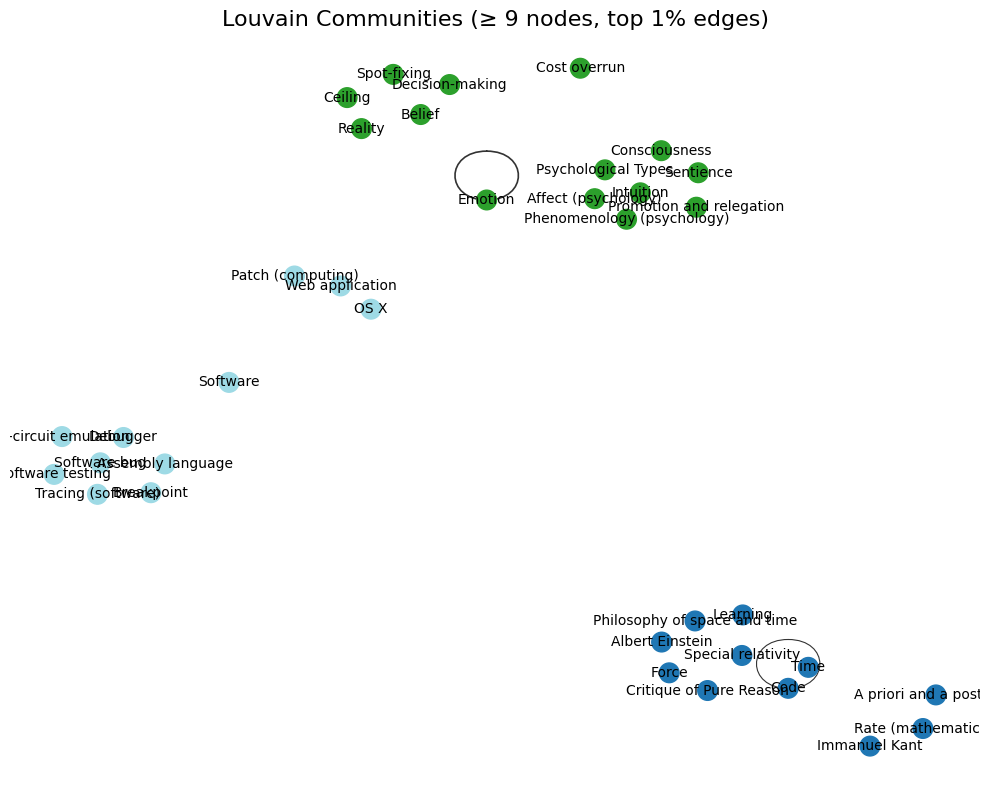

In [ ]:
# -- Parameters --
PERCENTILE = 99  # keep top 1% edges
MIN_COMM_SIZE = 9  # only show communities with >= this many nodes
SEED = 42  # for layout reproducibility

# -- Data prep: assume df_clean and C are already defined --
# df_clean: DataFrame with one row per (doc_index, concept, relevance)
# C: NumPy array co-occurrence matrix, shape (n_feats, n_feats)
feat_names = sorted(df_concepts["concept"].unique())
assert C.shape == (
    len(feat_names),
    len(feat_names),
), "C and feat_names length mismatch!"

# Threshold edges by percentile (using pure NumPy)
C_arr = np.asarray(C)  # ensure it’s a NumPy array
i, j = np.triu_indices_from(C_arr, k=1)  # strictly above the diagonal
weights = C_arr[i, j]
thresh = np.percentile(weights, PERCENTILE)
C_thresh = np.zeros_like(C_arr)
C_thresh[C_arr >= thresh] = C_arr[C_arr >= thresh]

# Build and label graph
G = nx.from_numpy_array(C_thresh)
mapping = {i: feat for i, feat in enumerate(feat_names)}
G = nx.relabel_nodes(G, mapping)

# Run Louvain
partition = community_louvain.best_partition(
    G, weight="weight", random_state=SEED
)

# Filter small communities
sizes = Counter(partition.values())
keep_comms = {cid for cid, sz in sizes.items() if sz >= MIN_COMM_SIZE}
large_nodes = [n for n, cid in partition.items() if cid in keep_comms]
G_sub = G.subgraph(large_nodes).copy()
partition_sub = {n: partition[n] for n in large_nodes}

# Visualize with fewer nodes & stronger edges
fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(G_sub, seed=SEED)

# Draw only the largest communities
nx.draw_networkx_nodes(
    G_sub,
    pos,
    node_color=[partition_sub[n] for n in G_sub.nodes()],
    cmap=plt.get_cmap("tab20"),
    node_size=200,  # slightly bigger so small groups stand out
    ax=ax,
)

# Draw only edges in the top 1% (instead of 5%) to unclutter
edge_weights = np.array([G_sub[u][v]["weight"] for u, v in G_sub.edges()])
edge_thresh = np.percentile(edge_weights, 99)
heavy_edges = [
    (u, v)
    for (u, v), w in zip(G_sub.edges(), edge_weights)
    if w >= edge_thresh
]
nx.draw_networkx_edges(
    G_sub,
    pos,
    edgelist=heavy_edges,
    width=[G_sub[u][v]["weight"] * 0.2 for u, v in heavy_edges],
    alpha=0.8,
    ax=ax,
)

nx.draw_networkx_labels(G_sub, pos, font_size=10, ax=ax)
ax.set_title(
    f"Louvain Communities (≥ {MIN_COMM_SIZE} nodes, top 1% edges)", fontsize=16
)
ax.axis("off")
plt.tight_layout()
plt.show()

In [6]:
# Count sizes of each community in your filtered subgraph
sizes = Counter(partition_sub.values())

# Build a DataFrame and sort by size
df_sizes = (
    pd.DataFrame.from_dict(sizes, orient="index", columns=["size"])
    .rename_axis("community_id")
    .reset_index()
    .sort_values("community_id", ascending=True)
)


print(f"\nTotal communities (size ≥ {MIN_COMM_SIZE}): {len(df_sizes)}")
df_sizes


Total communities (size ≥ 9): 3


,community_id,size
0,0,11
1,1,14
2,5,11


In [7]:
comm_members = defaultdict(list)
for node, cid in partition.items():
    if sizes[cid] >= MIN_COMM_SIZE:
        comm_members[cid].append(node)

for cid, members in comm_members.items():
    print(f"\nCommunity {cid} ({len(members)} nodes):")
    print(", ".join(members))


Community 0 (11 nodes):
A priori and a posteriori, Albert Einstein, Code, Critique of Pure Reason, Force, Immanuel Kant, Learning, Philosophy of space and time, Rate (mathematics), Special relativity, Time

Community 1 (14 nodes):
Affect (psychology), Belief, Ceiling, Consciousness, Cost overrun, Decision-making, Emotion, Intuition, Phenomenology (psychology), Promotion and relegation, Psychological Types, Reality, Sentience, Spot-fixing

Community 5 (11 nodes):
Assembly language, Breakpoint, Debugger, In-circuit emulation, OS X, Patch (computing), Software, Software bug, Software testing, Tracing (software), Web application


In [ ]:
# Make a dense adjacency matrix
affinity = nx.to_numpy_array(G, nodelist=feat_names)

# Compute the spectral embedding of your affinity matrix
X_emb = spectral_embedding(affinity, n_components=3, random_state=42)

# Run KMeans in that 3-dim space
km = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_emb)
labels_emb = km.labels_

# Silhouette in Euclidean space
score_emb = silhouette_score(X_emb, labels_emb, metric="euclidean")
print("Spectral-embedding silhouette (k=3):", score_emb)

Spectral-embedding silhouette (k=3): 0.5716061534066341


c:\Users\britt\source\repos\notebook-to-prod-template\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [20]:
# partition_sub: dict of only the kept nodes → community_id
comm_members = defaultdict(list)
for node, cid in partition_sub.items():
    comm_members[cid].append(node)

for cid, members in comm_members.items():
    print(f"\nCommunity {cid} ({len(members)} nodes):")
    print(", ".join(members))


Community 0 (11 nodes):
A priori and a posteriori, Albert Einstein, Code, Critique of Pure Reason, Force, Immanuel Kant, Learning, Philosophy of space and time, Rate (mathematics), Special relativity, Time

Community 1 (14 nodes):
Affect (psychology), Belief, Ceiling, Consciousness, Cost overrun, Decision-making, Emotion, Intuition, Phenomenology (psychology), Promotion and relegation, Psychological Types, Reality, Sentience, Spot-fixing

Community 5 (11 nodes):
Assembly language, Breakpoint, Debugger, In-circuit emulation, OS X, Patch (computing), Software, Software bug, Software testing, Tracing (software), Web application


In [ ]:
feat_names  # a list of all concepts in the same order as your affinity matrix
large_nodes  # a list of the subset of those concepts you kept

# Make a dense adjacency matrix
affinity = nx.to_numpy_array(G, nodelist=feat_names)

large_idxs = [feat_names.index(node) for node in large_nodes]

# Suppose you DID prune to large_nodes before embedding:
sub_affinity = affinity[np.ix_(large_idxs, large_idxs)]
X_sub_emb = spectral_embedding(sub_affinity, n_components=3, random_state=42)
labels_sub = KMeans(n_clusters=3, random_state=42).fit_predict(X_sub_emb)

# Now map back:
emb_partition = dict(zip(large_nodes, labels_sub))

for node, cid in emb_partition.items():
    comm_members[cid].append(node)

for cid, members in comm_members.items():
    print(f"\nSpectral Cluster {cid} ({len(members)} concepts):")
    print(", ".join(members))


Spectral Cluster 0 (28 concepts):
A priori and a posteriori, Albert Einstein, Code, Critique of Pure Reason, Force, Immanuel Kant, Learning, Philosophy of space and time, Rate (mathematics), Special relativity, Time, Affect (psychology), Belief, Ceiling, Consciousness, Cost overrun, Decision-making, Emotion, Intuition, OS X, Patch (computing), Phenomenology (psychology), Promotion and relegation, Psychological Types, Reality, Sentience, Spot-fixing, Web application

Spectral Cluster 1 (25 concepts):
Affect (psychology), Belief, Ceiling, Consciousness, Cost overrun, Decision-making, Emotion, Intuition, Phenomenology (psychology), Promotion and relegation, Psychological Types, Reality, Sentience, Spot-fixing, A priori and a posteriori, Albert Einstein, Code, Critique of Pure Reason, Force, Immanuel Kant, Learning, Philosophy of space and time, Rate (mathematics), Special relativity, Time

Spectral Cluster 5 (11 concepts):
Assembly language, Breakpoint, Debugger, In-circuit emulation, OS

c:\Users\britt\source\repos\notebook-to-prod-template\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.




Cluster 2 (98 concepts):
A priori and a posteriori, Affect (psychology), Ageing, Albert Einstein, Answer, Aristotle, Assembly language, Automated online assistant, Belief, Breakpoint, Ceiling, Code, Complex reflection group, Computer, Computer science, Confidence trick, Consciousness, Corruption, Cost overrun, Critique of Pure Reason, Curiosity, Customer, Customer relationship management, Customer satisfaction, Customer service, Customer support, Day, Debugger, Decision-making, Electronic document, Emotion, Evoked potential, Externalism, Force, Form (document), Fundraising, Gottfried Wilhelm Leibniz, Home Alone, Human, Human voice, Immanuel Kant, In-circuit emulation, Interest (emotion), Interrogative, Intuition, Invisibility, Keep, Learning, Lecture, Lighting, Loaded question, Mandatory retirement, Meeting, Metaphysics, Motivation, Navigation, Night sky, Nocturne, OS X, Old age, Online community, Patch (computing), Pension, Phenomenology (psychology), Philosophy of space and time, Ph

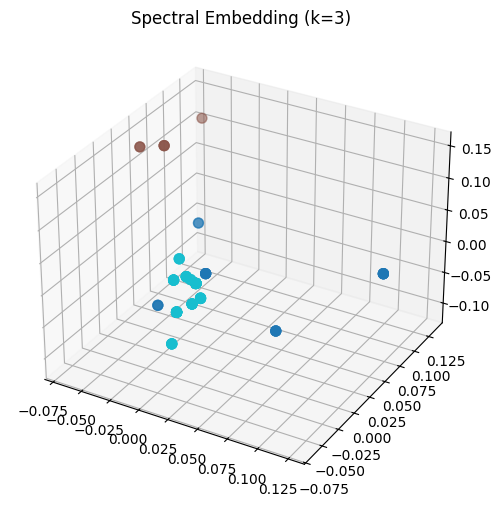

In [22]:
# partition_sub is node→community for your pruned graph, but
# if you want the full spectral labels on the entire affinity:
labels_emb = km.labels_  # from your KMeans on X_emb
feat_names = sorted(df_concepts["concept"].unique())

# Map back label→concept
emb_partition = dict(zip(feat_names, labels_emb))

comms = defaultdict(list)
for feat, cid in emb_partition.items():
    comms[cid].append(feat)

for cid, members in comms.items():
    print(f"\nCluster {cid} ({len(members)} concepts):")
    print(", ".join(members))


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
xs, ys, zs = X_emb[:, 0], X_emb[:, 1], X_emb[:, 2]
ax.scatter(xs, ys, zs, c=labels_emb, cmap="tab10", s=50)
ax.set_title("Spectral Embedding (k=3)")
plt.show()

In [23]:
# X_sub_emb: your subgraph’s embedding of shape (n_nodes, 3)
# large_nodes: list of those node names, same length as X_sub_emb
# labels_emb: the k-means labels on X_sub_emb, length n_nodes

# compute large_idxs so we slice the right rows/cols
large_idxs = [feat_names.index(n) for n in large_nodes]

sub_affinity = affinity[np.ix_(large_idxs, large_idxs)]
X_sub_emb = spectral_embedding(sub_affinity, n_components=3, random_state=42)


labels_sub = KMeans(n_clusters=3, random_state=42).fit_predict(X_sub_emb)
# labels_sub now has length == len(large_nodes) == 36


df3d = pd.DataFrame(
    X_sub_emb,
    columns=("x", "y", "z"),
    index=large_nodes,  # set the index to your node names
)
df3d["cluster"] = labels_sub  # length matches the index now
df3d["label"] = df3d.index  # hover info


df3d["cluster"] = df3d["cluster"].astype(str)

fig = px.scatter_3d(
    df3d,
    x="x",
    y="y",
    z="z",
    color="cluster",
    hover_name="label",
    title="Spectral Embedding (k=3)",
)
fig.show()

c:\Users\britt\source\repos\notebook-to-prod-template\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



---

### 6.1 Building the Graph with NetworkX

**Undirected**  
An edge **(A, B)** is the same as **(B, A)**. You’re just counting **co-occurrence**, not directionality.

**Weighted**  
Each edge carries a numeric weight—how many documents the pair co-occurs in—which you can use to size or filter edges.

---

#### 🔀 Directed vs. Undirected

| Aspect         | Undirected                        | Directed                                        |
|----------------|-----------------------------------|--------------------------------------------------|
| **Edge type**  | (A, B) = (B, A)                  | (A → B) and (B → A) are distinct                |
| **When to use**| Pure co-occurrence, symmetric relation | Order matters (e.g. “A causes B,” “A precedes B”) |

**Example Directed Use Cases:**
- Temporal flow: *“first I felt anxious, then relieved”* → **anxious → relieved**  
- Causal modeling: *emotion → behavior*

Parameters in `build_semantic_graph(df_concepts, threshold=1, directed=False)`

`threshold` (int): minimum co-occurrence count to include an edge.

`directed` (bool): if `True`, returns an `nx.DiGraph` capturing sequence-based edges; if `False`, an undirected `nx.Graph`.


---
Once your graph is built, you can choose how to lay it out and style it.

---


In [ ]:
# directed
G_dir = build_semantic_graph(df_concepts, threshold=2, directed=True)

# compute centrality
G_dir_metrics = compute_centrality(G_dir)  # e.g. degree
# metrics is a dict { node: degree_centrality }

# detect communities
G_dir_comm_sets = detect_communities(G_dir)  # list of sets

# comm_sets is a list of sets, where each set contains nodes
# in the same community
G_dir_comm_map = node_to_community_map(
    G_dir_comm_sets
)  # flatten to {node:community_id}

# peek at the very top co-occurrences
G_dir_top_pairs = sorted(edges, key=lambda e: e[2], reverse=True)[:10]

directed_pairs = pd.DataFrame(
    G_dir_top_pairs, columns=["Concept A", "Concept B", "Count"]
)
directed_pairs

,Concept A,Concept B,Count
0,Affect (psychology),Emotion,2
1,Affect (psychology),Intuition,2
2,Affect (psychology),Phenomenology (psychology),2
3,Affect (psychology),Psychological Types,2
4,Code,Time,2
5,Emotion,Intuition,2
6,Emotion,Phenomenology (psychology),2
7,Emotion,Psychological Types,2
8,Intuition,Phenomenology (psychology),2
9,Intuition,Psychological Types,2


### 6.2 Visualizing the Graph

---

#### Edge Weights
* Continuous weights: feed directly into NetworkX algorithms (`betweenness_centrality(weight="weight")`, etc.)

* Thresholding: hide edges with `weight < threshold` to reduce noise

Normalization: post-process `C` if you need to compare across corpora of different sizes

🎚 Controlled by `threshold` in build and in `visualize_graph` by `edge_threshold` (drop low-weight edges) and `edge_width_scale` (line-width = weight × scale).


---

#### Labels

- **Node labels**: concept names — toggle via `node_labels=True/False`
- **Edge labels**: numeric weight annotations — toggle via show_edge_labels=True/False


---

#### Layouts

> The `layout` and `layout_kwargs` parameters let you choose from:
> - spring layout
> - Kamada–Kawai
> - circular
> - custom coordinate layouts  
> … and fine-tune their appearance.

---

#### Coloring & Sizing 

> `metrics` (dict): pre-computed values (e.g. degree, betweenness)  
> `node_size_by` ("degree", "betweenness" or None)  
> `size_scale` (float): multiplier for node sizes  
> `comm_map` (dict): maps each node → community index  
> `node_color_by` ("community" or name of metric)  
> `cmap` (string): matplotlib colormap  
Color encodes categories (communities) or continuous scores (centrality, emotion, function).
---

####  Putting It All Together

| Graph Type            | When to Use                                                         |
|-----------------------|---------------------------------------------------------------------|
| **Undirected + Weighted** | For symmetric co-occurrence—strength of conceptual link        |
| **Directed + Weighted**   | When order or dependency matters (e.g. cause-effect, timeline) |

By selectively combining structure, weight, layout, and styling, your semantic network becomes a lens into how concepts emerge and interact across your corpus.
